## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import os
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [4]:
with open('mtx_dist.pickle', 'wb') as handle:
    pickle.dump({'mtx':mtx,'dist':dist}, handle, protocol=pickle.HIGHEST_PROTOCOL)

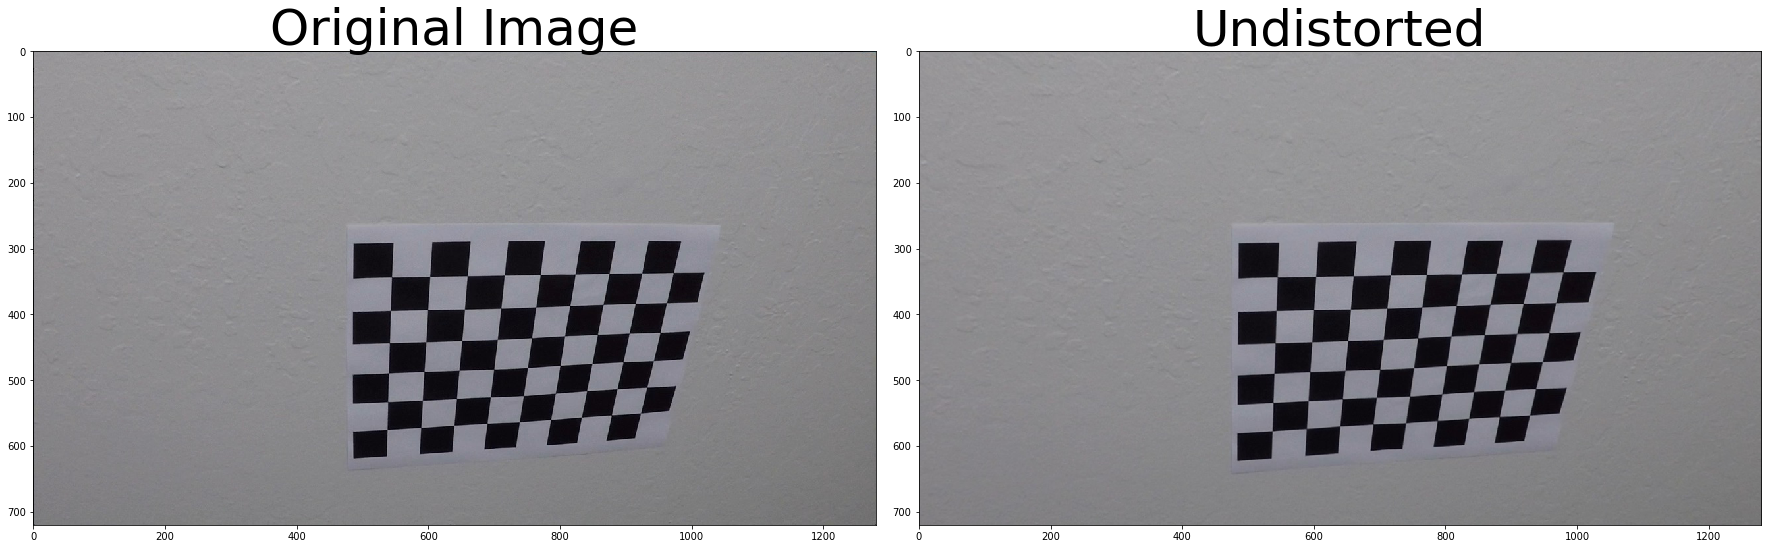

In [5]:
# Read in an image
image = mpimg.imread('camera_cal/calibration10.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist, cmap='gray')
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("output_images/undistort_output.jpg")

In [6]:
# apply distortion matrix to undistort camera images
def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

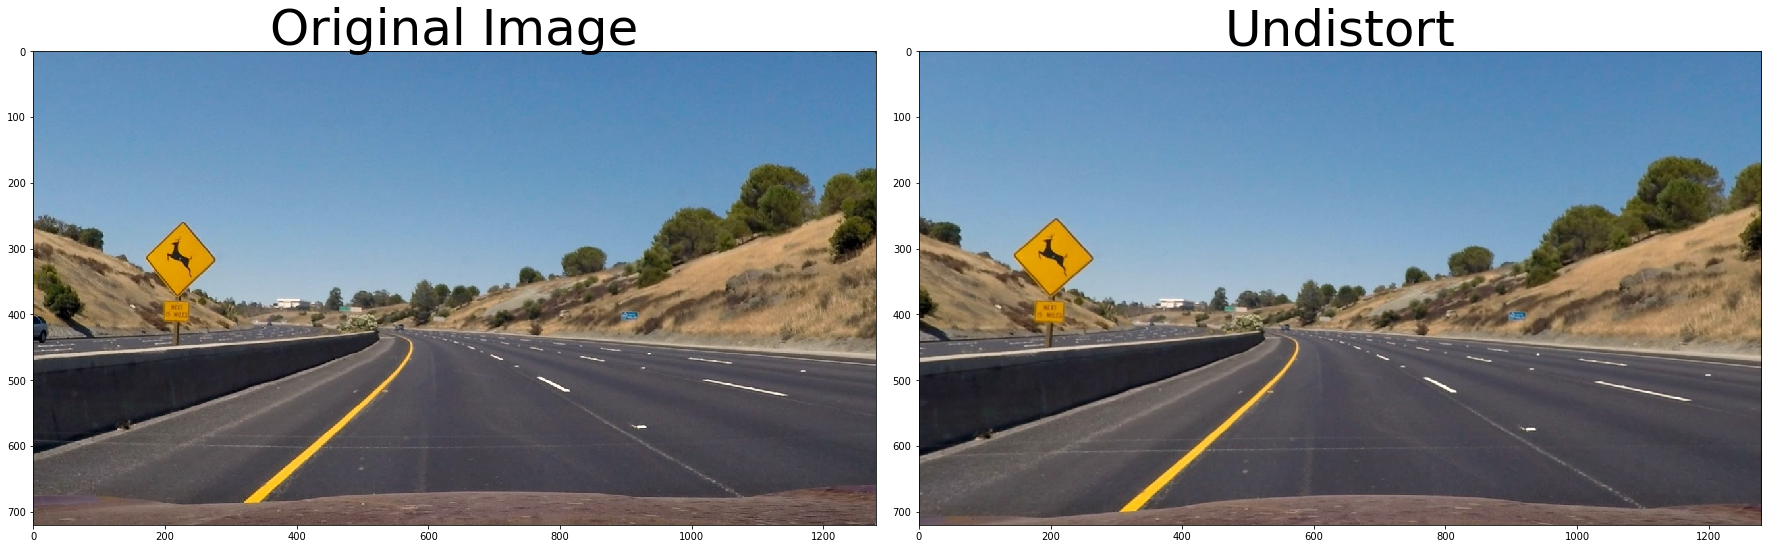

In [8]:
# Read in an image
image = mpimg.imread('test_images/test2.jpg')
undist = undistort(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist, cmap='gray')
ax2.set_title('Undistort', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("output_images/example/undistort.jpg")

In [9]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [10]:
# can use hls saturation for threshold or gray
def abs_sobel_thresh(img, orient='x', sobel_kernel=7, thresh=(0, 255), use_saturation=False):
    # Calculate directional gradient
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if use_saturation:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = hls[:,:,2] # s_channel
    # 
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt((sobelx**2)+(sobely**2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag > mag_thresh[0]) & (gradmag < mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir > thresh[0]) & (grad_dir < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def hls_threshold(img, s_thresh=(170, 255)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
     # Threshold color channel
    #s_channel = np.uint8(255*s_channel/np.max(s_channel))
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel) > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

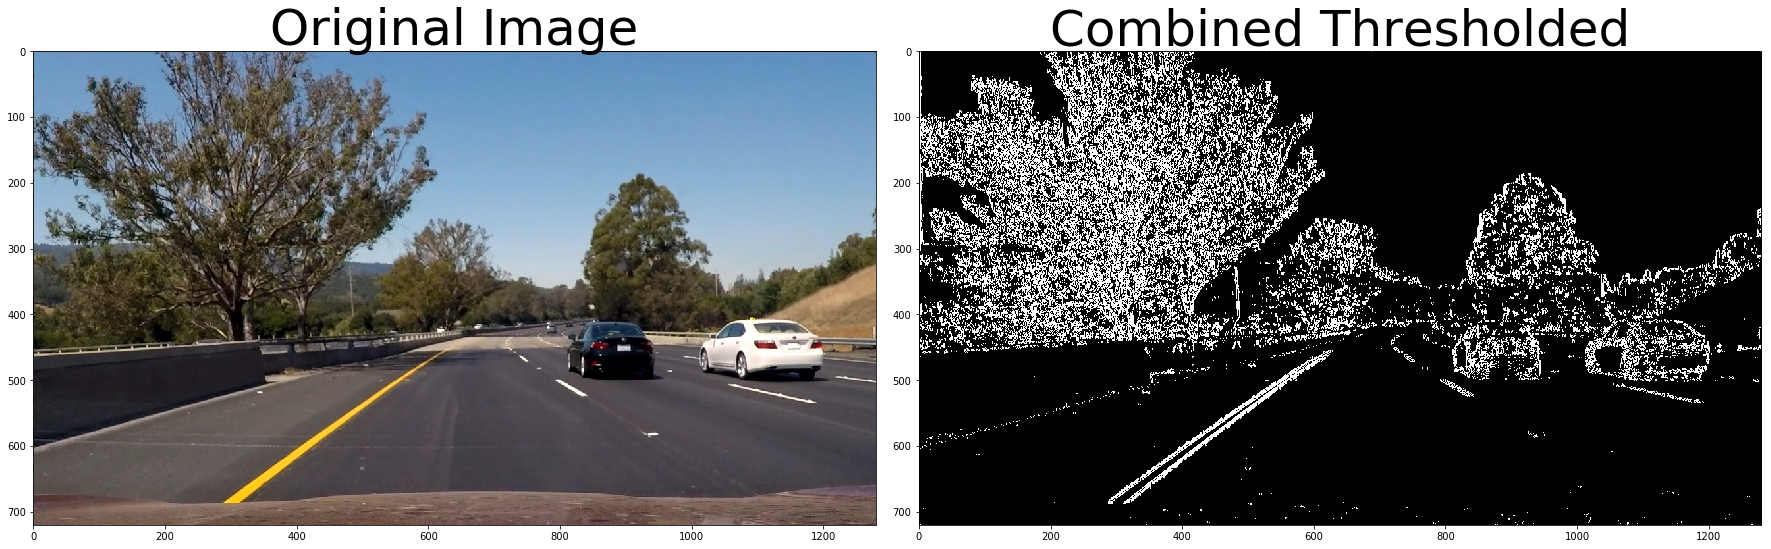

In [12]:
# Binary Image with emphasis on lane lines
def combined_binary(image, ksize=3):
#     image = cv2.GaussianBlur(image, (ksize, ksize), 0)
    #Apply each of the thresholding functions
    #grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    #col_thresh = hls_threshold(image, s_thresh=(170, 255))
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    gradxAlt = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100),use_saturation=True)

    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
    #dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.8, np.pi/2))

    combined = np.zeros_like(gradx)
    combined[ ((mag_binary == 1) & (gradx == 1))] = 1
    #combined[ ((combined == 1) | (col_thresh == 1))] = 1
    combined[ ((combined == 1) | (gradxAlt == 1))] = 1

    return combined

### TEST ###
# Read in an image
image = mpimg.imread('test_images/test6.jpg')
combined = combined_binary(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Thresholded', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("output_images/example/combined_binary.jpg")

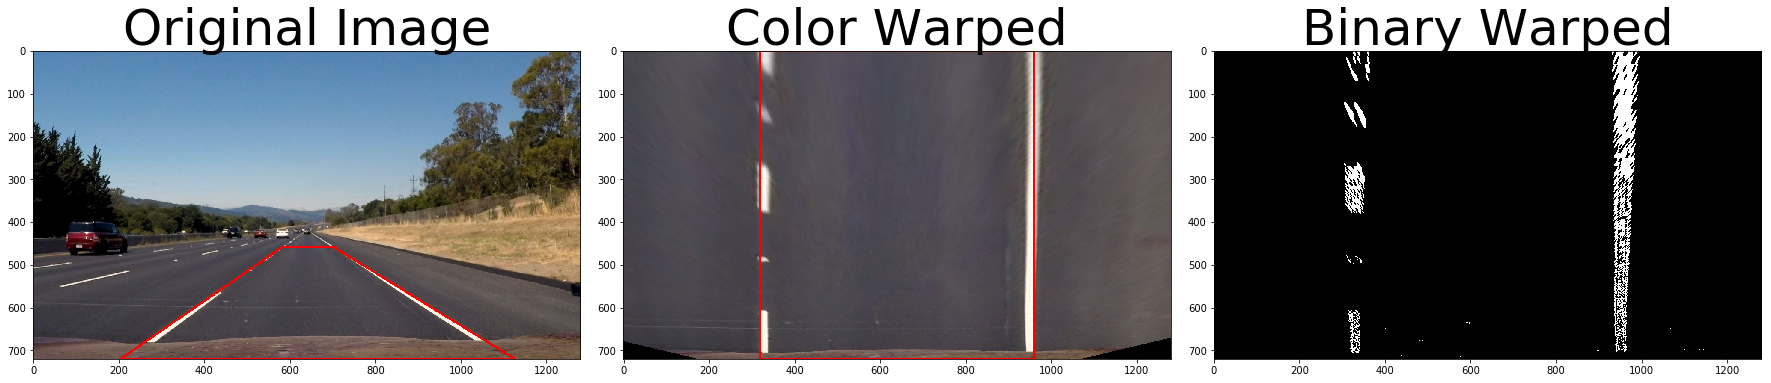

In [13]:
def warp_transform(img, offset=400, test_mode=False):
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    out_img = None
    src = np.float32(
    [[(img_size[0] / 2) - 57, img_size[1] / 2 + 97],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 97]])
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    if test_mode:
        #draw the polygon defined by "vertices" with the color
        dest_vec = np.array([dst], dtype=np.int32)
        cv2.polylines(warped, dest_vec,True, 255,3)
        out_img = np.copy(img)
        src_vec = np.array([src], dtype=np.int32)
        cv2.polylines(out_img, src_vec,True, 255,3)
    return out_img,warped,M,dst,src

### TEST ###
image = mpimg.imread('test_images/straight_lines2.jpg')

img,warped,M,dst,src = warp_transform(image,400,True)
_,binary_warped,M,dst,src = warp_transform(combined_binary(image))

# Plot the result
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Color Warped', fontsize=50)
ax3.imshow(binary_warped, cmap='gray')
ax3.set_title('Binary Warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("output_images/example/binary_warped.jpg")

avg curvature in meters 1366.64660534


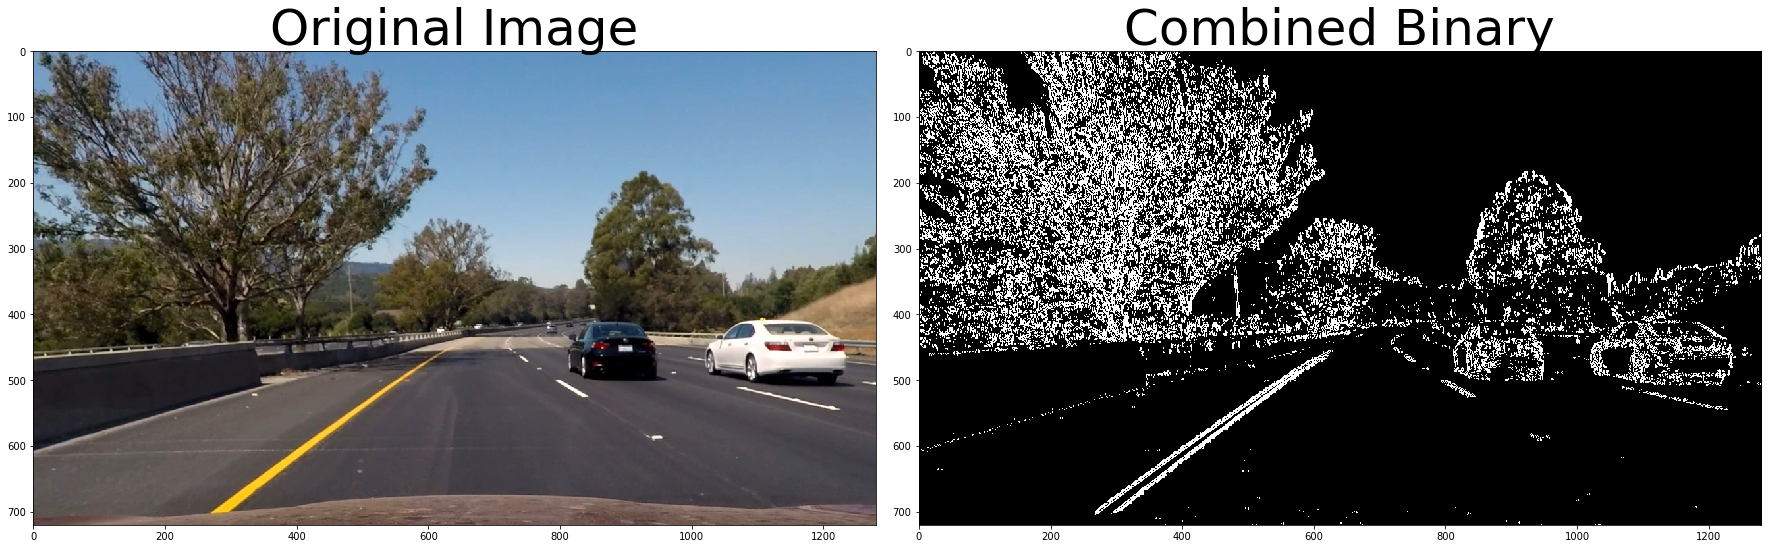

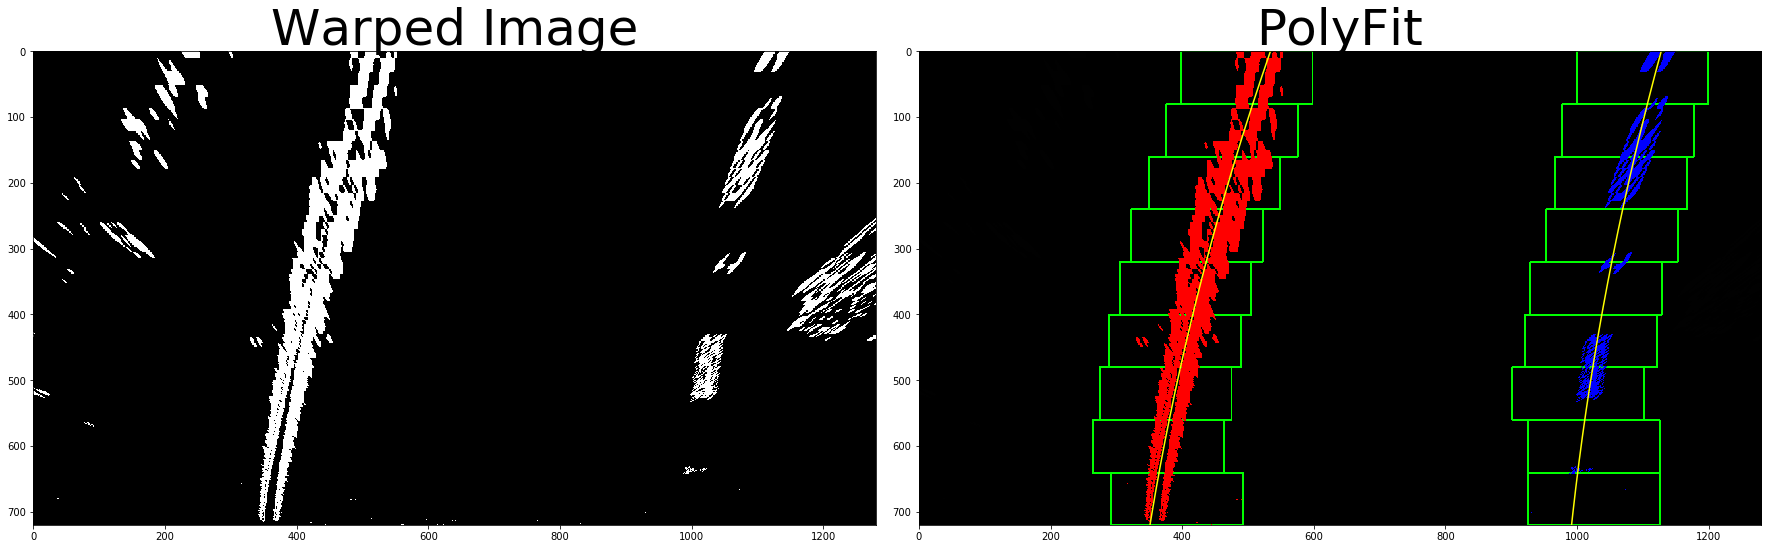

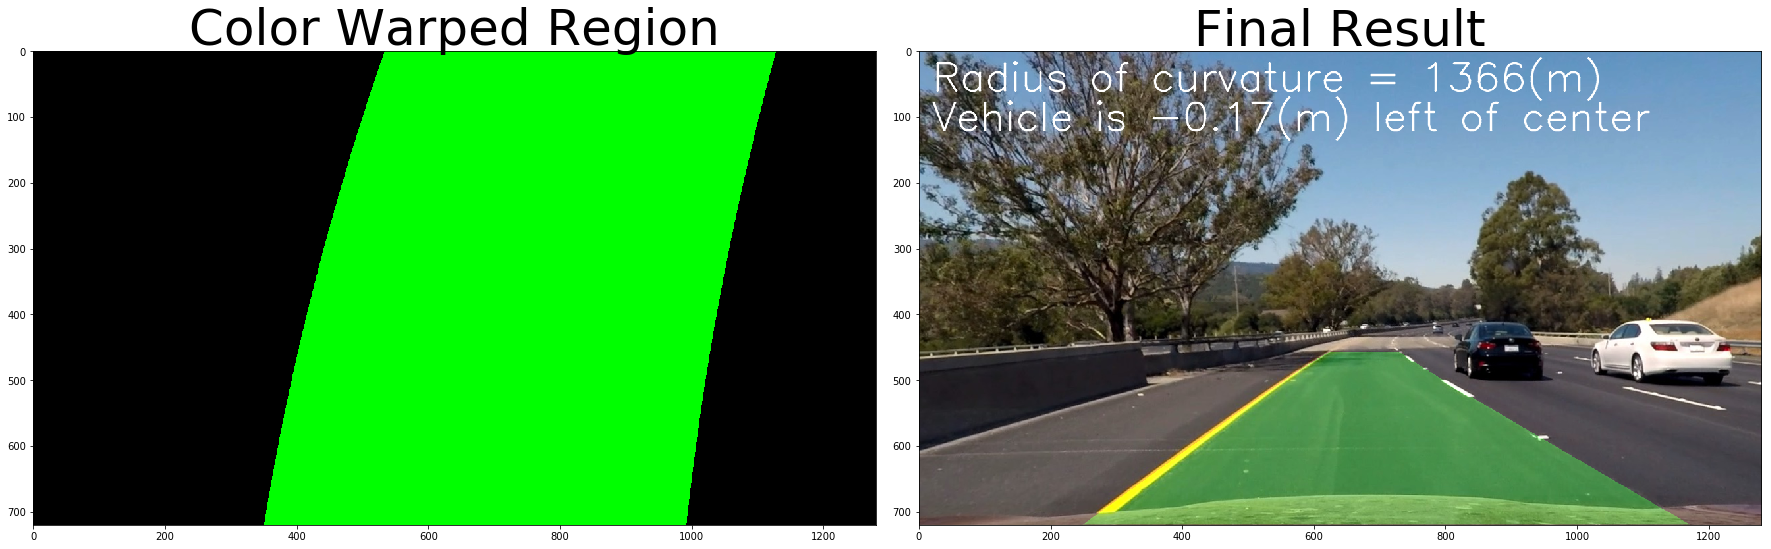

In [14]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def map_lane(left_fitx,right_fitx,ploty,warped):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return color_warp

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    return out_img, left_fitx,right_fitx,ploty,left_fit,right_fit

def measure_curvature_pixels(left_fit,right_fit,ploty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
#     ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def measure_curvature_real(leftx,rightx,ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

### TEST ###

image = undistort(mpimg.imread('test_images/test6.jpg')) # Undistort
combined = combined_binary(image)                      # Combined_binary
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("output_images/example/step1.jpg")

_,warped,M,dst,src = warp_transform(combined)            # Warped image

# Detect Lanes & Fit line
out_img, left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(warped)

# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(left_fitx,right_fitx,ploty)

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(left_fitx,right_fitx,ploty)

# print(left_curverad, 'm', right_curverad, 'm')
avgcurve = (left_curverad+right_curverad)/2
print('avg curvature in meters',avgcurve)

# Calculate offset from center
left_value = left_fit[0]*image.shape[0]**2 + left_fit[1]*image.shape[0] + left_fit[2]
right_value = right_fit[0]*image.shape[0]**2 + right_fit[1]*image.shape[0] + right_fit[2]
lane_center = (right_value+left_value)/2
# lane_center = (right_fitx[0]+left_fitx[0])/2
xm_per_pix = 3.7/700
image_center = image.shape[1]/2
offset_center = round((image_center-lane_center)*xm_per_pix,2)

# Plot Warped image and PolyFit
fx, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fx.tight_layout()
ax1.imshow(warped, cmap='gray')
ax1.set_title('Warped Image', fontsize=50)
ax2.imshow(out_img, cmap='gray')
ax2.set_title('PolyFit', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
fx.savefig("output_images/example/step2.jpg")

# Color Warp region
color_warp = map_lane(left_fitx,right_fitx,ploty,warped)
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

# Print curvature and offset on image
font = cv2.FONT_HERSHEY_SIMPLEX
offset_label = 'left' if offset_center < 0 else 'right'
cv2.putText(result,'Radius of curvature = %s(m)'%int(avgcurve),(20,60), font, 2,(255,255,255),2,cv2.LINE_AA)
cv2.putText(result,'Vehicle is %s(m) %s of center'%(offset_center,offset_label),(20,120), font, 2,(255,255,255),2,cv2.LINE_AA)

# Plot the Color warp and Final Result
fy, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fy.tight_layout()
ax1.imshow(color_warp, cmap='gray')
ax1.set_title('Color Warped Region', fontsize=50)
ax2.imshow(result, cmap='gray')
ax2.set_title('Final Result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
fy.savefig("output_images/example/step3.jpg")


In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

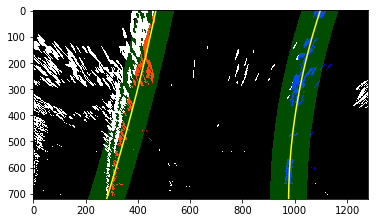

In [16]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty,left_fit,right_fit

def search_around_poly(binary_warped,left_fit,right_fit,test_mode=False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 70

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty,left_fit,right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    result = None
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    if test_mode:
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result, left_fitx,right_fitx,ploty,left_fit,right_fit
    ## End visualization steps ##

### TEST ###
image = mpimg.imread('test_images/test5.jpg')
binary_img = combined_binary(image) # combined_binary
_,binary_warped,M,dst,src = warp_transform(binary_img) # binary warped
# reuse prev fit values
out_img, left_fitx,right_fitx,ploty,left_fit,right_fit = search_around_poly(binary_warped,left_fit,right_fit,True)
# Plot the result
plt.imshow(out_img)
# Plot the polynomial lines onto the image
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

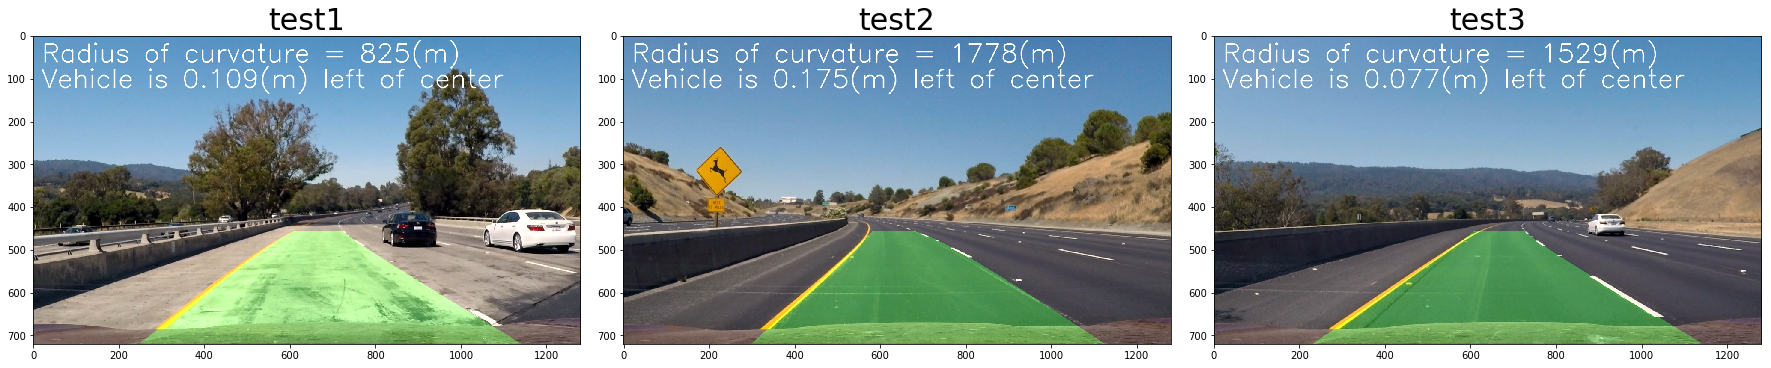

In [17]:
# Keep track and average fits over time
def update_line(line,fit):
    if fit is None:
        line.detected = False
        line.current_fit = []
    else:
        line.detected = True
        line.current_fit.append(fit)
        # trim current fit n=20
        if len(line.current_fit) > 5:
            line.current_fit = line.current_fit[5:]
        line.best_fit = np.average(line.current_fit, axis=0)
        
def process_image(image):
#     global lline,rline
    undist = undistort(image) # undistort
    binary_img = combined_binary(undist,3) # combined binary thresholded 
    _,binary_warped,M,dst,src = warp_transform(binary_img) # binary warped to birds eye view
    # return np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    if lline.detected and rline.detected: # use best fit if available
        
        _,left_fitx,right_fitx,ploty,left_fit,right_fit = search_around_poly(binary_warped,lline.best_fit,rline.best_fit)
        update_line(lline,left_fit)
        update_line(rline,right_fit)

    else: # find lanes and fit line
        _,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(binary_warped)
        update_line(lline,left_fit)
        update_line(rline,right_fit)        
        
    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad = measure_curvature_real(left_fitx,right_fitx,ploty)
    avg_curve = (left_curverad+right_curverad)/2

    # calculate offset from center
    # lane_center = (right_fitx[0]+left_fitx[0])/2
    left_value = left_fit[0]*image.shape[0]**2 + left_fit[1]*image.shape[0] + left_fit[2]
    right_value = right_fit[0]*image.shape[0]**2 + right_fit[1]*image.shape[0] + right_fit[2]
    lane_center = (right_value+left_value)/2
    xm_per_pix = 3.7/700
    image_center = image.shape[1]/2
    offset_center = round((image_center-lane_center)*xm_per_pix,3)

    # color warp lane region
    color_warp = map_lane(left_fitx,right_fitx,ploty,binary_warped)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    inv_warp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, inv_warp, 0.3, 0)

    
    # Print curvature and offset on image
    font = cv2.FONT_HERSHEY_SIMPLEX
    offset_label = 'left' if offset_center < 0 else 'right'
    cv2.putText(result,'Radius of curvature = %s(m)'%int(avg_curve),(20,60), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle is %s(m) %s of center'%(abs(offset_center),offset_label),(20,120), font, 2,(255,255,255),2,cv2.LINE_AA)
    return result

### TEST ###
image1 = mpimg.imread('test_images/test1.jpg')
image2 = mpimg.imread('test_images/test2.jpg')
image3 = mpimg.imread('test_images/test3.jpg')
lline = Line()
rline = Line()

fy, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
fy.tight_layout()
ax1.imshow(process_image(image1))
ax1.set_title('test1', fontsize=30)
ax2.imshow(process_image(image2))
ax2.set_title('test2', fontsize=30)
ax3.imshow(process_image(image3))
ax3.set_title('test3', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [18]:
lline = Line()
rline = Line()
# Process All Test Images
for filename in os.listdir("test_images/"):
    # Read in an image
    image = mpimg.imread("test_images/%s" % filename)
    mpimg.imsave("output_images/%s" % filename,process_image(image))

In [20]:
video_output = 'test_videos_output/project_video4.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
# clip1 = VideoFileClip("project_video.mp4")
lline = Line()
rline = Line()
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video4.mp4
[MoviePy] Writing video test_videos_output/project_video4.mp4



 99%|█████████▉| 125/126 [00:35<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video4.mp4 

CPU times: user 16.8 s, sys: 8.02 s, total: 24.8 s
Wall time: 38.1 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))